In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from astropy import units as u, constants as const
from multiprocessing import Pool
import os
os.environ["OMP_NUM_THREADS"] = "1"

from pyphot import (unit, Filter)
# import bagpipes as pipes
import emcee

In [16]:
sylt_ids = np.load('../../contrastive_learning/sylt_ids.npz')['ids']
sylt_ids

array([ 980453716, 1143273115, 1197311621, 1228745162, 1271696125,
       1456016600, 1470729144, 1471313744, 1513805078, 1599741416,
       1621863463, 1695974542])

In [19]:
band_names = ['g','r','i','z','Y','J','K','W1','W2']
eff_wavs = [4862.24, 6460.63, 7850.77, 9199.28, 9906.83, 12681.01, 21588.53, 33526, 46028]

filters_pyphot={} # For deducing photometry from spectra
for band_name, file_name in zip(band_names, [
    "CTIO_DECam.g",
    "CTIO_DECam.r",
    "CTIO_DECam.i",
    "CTIO_DECam.z",
    "CTIO_DECam.Y",
    "Paranal_VISTA.J",
    "Paranal_VISTA.Ks",
    "WISE_WISE.W1",
    "WISE_WISE.W2"
]):
    file = np.loadtxt(f'../filters/{file_name}.dat')

    wave = file[:,0]*unit['AA']
    transmit = file[:,1]
    filters_pyphot[band_name] = Filter(
        wave, transmit, name=band_name, dtype='photon', unit='Angstrom'
    )

filters_list = np.loadtxt('./filters_list_grizYJKW12.txt', dtype="str") # For bagpipes

df = pd.read_csv('../../selecting_data/objs_7102.csv',
                 index_col=0).loc[sylt_ids]
mag_df = df[[f'{band}_mag' for band in band_names]]
magerr_df = df[[f'{band}_magerr' for band in band_names]]
flux_df = df[[f'{band}_flux' for band in band_names]]
fluxerr_df = df[[f'{band}_fluxerr' for band in band_names]]

In [30]:
mag_df

,g_mag,r_mag,i_mag,z_mag,Y_mag,J_mag,K_mag,W1_mag,W2_mag
coadd_object_id,,,,,,,,,
980453716,99.0000,99.000000,23.031525,20.428234,20.438257,19.191986,19.083292,18.946850,18.905692
1143273115,25.0686,23.085131,22.725275,20.184122,20.193619,19.422779,18.890154,19.039086,18.773871
1197311621,99.0000,99.000000,24.378326,20.850765,21.276281,20.657713,19.950358,19.768550,19.267141
1228745162,99.0000,24.031557,21.857098,19.879082,20.034571,19.424444,19.258778,19.306748,19.251762
1271696125,99.0000,99.000000,24.562616,20.508789,20.371948,19.759610,18.981762,18.813231,18.760390
1456016600,99.0000,25.496801,22.687263,20.342350,20.380072,19.915758,19.701619,20.073762,19.911150
1470729144,99.0000,25.624350,23.115353,20.600224,21.004805,20.576065,19.973560,20.024400,19.832961
1471313744,99.0000,99.000000,23.658253,19.883915,20.792187,19.883660,19.193697,18.720948,18.385741
1513805078,99.0000,25.514256,22.932396,20.486546,20.559446,20.254638,20.215853,19.873223,19.881519


In [21]:
def load_grizYJKW12(ID):    
    ID=int(ID)
    
    fluxes = flux_df.loc[ID]
    fluxerrs = fluxerr_df.loc[ID] / 3 # Table has the 3sigma error; bagpipes probably wants the 1sigma
    photometry = np.vstack((flux_df.loc[ID],
                            fluxerr_df.loc[ID])).T
    return photometry

<ErrorbarContainer object of 3 artists>

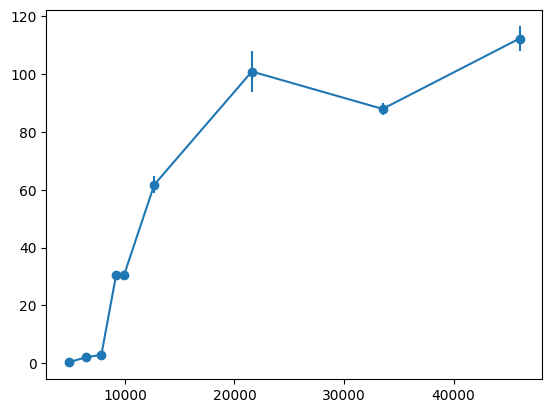

In [29]:
eg_phot = load_grizYJKW12(sylt_ids[1])
plt.errorbar(
    eff_wavs,
    eg_phot[:,0],
    yerr=eg_phot[:,1],
    marker='o'
)
# plt.xscale('log')
# plt.ylim([0,1000])

In [31]:
def package_model_components(t0,t1,mass,metallicity,dust_av,zgal):
    constant = {}  # Star formation - tophat function
    constant["age_max"] = t0 # Time since SF switched on: Gyr
    constant["age_min"] = t1 # Time since SF switched off: Gyr
    constant["massformed"] = mass # vary log_10(M*/M_solar) between 1 and 15
    constant["metallicity"] = metallicity # vary Z between 0 and 2.5 Z_oldsolar

    dust = {}  # Dust component
    dust["type"] = "Calzetti"  # Define the shape of the attenuation curve
    dust["Av"] = dust_av  # magnitudes
    
    nebular = {} # Nebular emission component
    nebular["logU"] = -3

    model_components = {}  # The model components dictionary
    model_components["redshift"] = zgal  # Observed redshift
    model_components["constant"] = constant
    model_components["dust"] = dust
    model_components["nebular"] = nebular
    
    return model_components

model_components = package_model_components(0.,0.5,10,0.2,0.2,1)

bagpipes_galaxy_model = pipes.model_galaxy(
    model_components,
    filt_list=filters_list,
    phot_units="mujy",
    spec_wavs=np.arange(6000., 50000., 5.)
)

def galaxy_BAGPIPES_photometry(t0,t1,mass,metallicity,dust_av,zgal):
    model_components = package_model_components(
        t0, t1, mass, metallicity, dust_av, zgal
    )
    bagpipes_galaxy_model.update(model_components)
    return bagpipes_galaxy_model.photometry

def galaxy_BAGPIPES_spectroscopy(t0,t1,mass,metallicity,dust_av,zgal):
    model_components = package_model_components(t0, t1, mass, metallicity, dust_av, zgal)
    bagpipes_galaxy_model.update(model_components)
    wavs = bagpipes_galaxy_model.wavelengths # Rest frame
    flxs = bagpipes_galaxy_model.spectrum_full # ergscma
    
    wavs*=(1+zgal)*u.AA # Redshifting
    flxs*=(u.erg/u.s/(u.cm**2)/u.AA) * (wavs**2)/const.c # Converting F_lambda to F_nu
    flxs=flxs.to(u.Jy).value*1e6 # muJy
    wavs=wavs.value # AA
    return wavs, flxs

NameError: name 'pipes' is not defined

In [31]:
modeldir_dict = {
        'vdb': './jwst_etc_quasar_templates/vandenberk2001_z=0_fnu_noscale.txt',
        'sls': './jwst_etc_quasar_templates/selsing2016_z=0_fnu_noscale.txt',
        'cln': './jwst_etc_quasar_templates/Colina_Quasar_z=0_ETC-Glikman+Hernan-Caballero.txt',
        'mcg': './jwst_etc_quasar_templates/mcgreer_z75qso.dat'
    }
model_qso = np.loadtxt(modeldir_dict['vdb'], skiprows=1)
# get tophat filter at 1450
filter_m_1450_file = np.loadtxt('filter_1450.txt')

def quasar_spectroscopy(M_QSO, z_QSO):
    wave = filter_m_1450_file[:,0] * unit['AA'] *(1+z_QSO)
    transmit = filter_m_1450_file[:,1]
    filter_m_1450 = Filter(wave, transmit, name='1450_tophat', dtype='photon', unit='Angstrom')
    # load quasar model, truncate Lyman-alpha forest
    spec_qso = model_qso[:,1]
    spec_qso[model_qso[:,0]*1e4<1215.16] = 0.0
    flux_qso = spec_qso *1e-3 * unit['Jy']
    wave_rest = model_qso[:,0]*1e4
    wavelength = model_qso[:,0]*1e4 *(1+z_QSO) * unit['AA']

    # rescale to desired apparent magnitude 1450 AA
    mag_1450 = -2.5*np.log10(filter_m_1450.get_flux(wavelength,flux_qso)/3631)
    flux_qso *= 10**( (M_QSO - mag_1450 ) / -2.5)
    return wavelength, flux_qso # in Jy
    
def quasar_photometry(M_QSO, z_QSO):
    wavelength, flux_qso = quasar_spectroscopy(M_QSO, z_QSO)
    wavelength*=unit['AA']
    flux_qso*=unit['Jy']
    
    mags = np.zeros(len(filters_pyphot))
    for i in range(len(mags)):
        mags[i] = -2.5 * np.log10(filters_pyphot[i].get_flux(wavelength, flux_qso)/3631)

    fluxes_muJy = 10**(np.array(mags)/ -2.5) *3631 *1e6 #muJy

    return fluxes_muJy

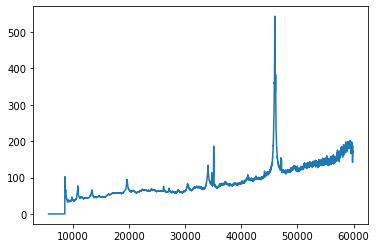

In [32]:
# get tophat filter at 1450, redshift to observed frame
M_QSO=20
z_QSO=6
file = np.loadtxt('filter_1450.txt')
wave = file[:, 0] * unit['AA'] *(1+z_QSO)
transmit = file[:, 1]
filter_m_1450 = Filter(wave, transmit, name='1450_tophat', dtype='photon', unit='Angstrom')

# load quasar model, truncate Lyman-alpha forest
spec_qso = model_qso[:,1]
spec_qso[model_qso[:,0]*1e4<1215.16] = 0.0
flux_qso = spec_qso *1e-3 * unit['Jy']
wavelength = model_qso[:,0]*1e4 *(1+z_QSO) * unit['AA']

# rescale to desired apparent magnitude 1450 AA
mag_1450 = -2.5*np.log10(filter_m_1450.get_flux(wavelength,flux_qso)/3631)
flux_qso *= 10**( (M_QSO - mag_1450 ) / -2.5)

plt.plot(wavelength.value, flux_qso.value*1e6)

In [39]:
def log_likelihood(theta, y, yerr, obj_type):
    fluxes_model = np.zeros(y.shape)
    
    if obj_type == 'GQ':
        t0,t1, mass, metallicity, dust_av, zgal, M_QSO, z_QSO = theta
    elif obj_type == 'Q':
        M_QSO, z_QSO = theta
    elif obj_type == 'G':
        t0,t1, mass, metallicity, dust_av, zgal = theta
    else:
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')
    
    if 'G' in obj_type:
        fluxes_model_galaxy = galaxy_BAGPIPES_photometry(t0,t1,mass, metallicity, dust_av, zgal)
        if np.sum(fluxes_model_galaxy)==0.:
            return -np.inf
        else:
            fluxes_model += fluxes_model_galaxy
        
    if 'Q' in obj_type:
        fluxes_model_quasar = quasar_photometry(M_QSO, z_QSO)
        fluxes_model += fluxes_model_quasar

    ##### if the SFH is unphysical, the BAGPIPES SED is only zeros - discard
    if np.sum(fluxes_model_galaxy)==0.:
        return -np.inf
    else:
        sigma2 = yerr**2
        return -0.5 * np.sum((y - fluxes_model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta, obj_type):
    ###### Define the log prior as uniform with boundaries in a realistic range
    if obj_type == 'GQ':
        t0,t1, mass, metallicity, dust_av, zgal, M_QSO, z_QSO = theta
        if (0<t0<13)&(0<t1<t0)&(8<mass<15)&(0<metallicity<2)&(0<dust_av<2)&(0<zgal<4)&(18<M_QSO<24)&(5.5<z_QSO<7):
            return 0.
        
    elif obj_type == 'Q':
        M_QSO, z_QSO = theta
        if (18<M_QSO<24)&(5.5<z_QSO<7):
            return 0.
        
    elif obj_type == 'G':
        t0,t1, mass, metallicity, dust_av, zgal = theta
        if (0<t0<13)&(0<t1<t0)&(8<mass<15)&(0<metallicity<2)&(0<dust_av<2)&(0<zgal<10):
            return 0.
    else:
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')

    return -np.inf

def log_probability(theta, y, yerr, obj_type):
    lp = log_prior(theta, obj_type)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr, obj_type)

In [34]:
def suggest_init(obj_type):
    mean_init_row = np.array([1,.1,10.0,0.3,0.5,1,20,6.0])
    if obj_type=='G':
        mean_init_row = mean_init_row[:6]
    elif obj_type=='Q':
        mean_init_row = mean_init_row[6:]
    elif obj_type!='GQ':
        raise ValueError(f'Invalid obj_type: {obj_type}. Must be either `G`, `Q`, or `GQ`.')
    ndim=len(mean_init_row)
    return mean_init_row + np.random.uniform(low=-.01,high=.01,
                                             size=ndim)

def initialise_chains(nwalkers, flux, err_flux, obj_type):
    base_init = suggest_init(obj_type)
    pos = np.tile(base_init, (nwalkers,1))
    i=0
    while np.all(pos[-1,:]==base_init) and i<nwalkers:
        ## Initialisation
#         new_row = pos[i,:] + np.random.randn(ndim)-.5
        new_row = suggest_init(obj_type)
    
        # Ensure that suggested initial point is actually in the prior
        if (log_prior(new_row, obj_type)!=-np.inf) & (log_likelihood(new_row, flux, err_flux, obj_type)!=-np.inf): 
            pos[i,:] = new_row
            i+=1
    return pos

def fit_sed(flux, err_flux, obj_type,
            nsteps=5000, discard=1000, thin=10, nwalkers=32,
           **kwargs): # kwargs to be passed to EnsembleSampler
    
    init = initialise_chains(nwalkers, flux, err_flux, obj_type)
    nwalkers, ndim = init.shape
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                        args=(flux, err_flux, obj_type),
                                        pool=pool,
                                       **kwargs)
        sampler.run_mcmc(init, nsteps, progress=True)

    samples = sampler.get_chain(flat=False,thin=thin,discard=discard)
    log_prob = sampler.get_log_prob(flat=False,thin=thin,discard=discard)

    return samples, log_prob

In [37]:
# n=np.random.randint(117) # Between 0 and 116 incl.
photometry = load_grizYJKW12(ids_117[0])
fluxes_muJy = photometry[:,0]
err_fluxes_muJy = photometry[:,1]

# print(f'Number: {n}\nID: {ids_117[n]}')

samples, log_prob = fit_sed(flux=fluxes_muJy, err_flux=err_fluxes_muJy, obj_type='GQ',
                            nsteps=10000, discard=4000, thin=2,
                            nwalkers=32, a=2.
                                )

/tmp/ipykernel_39617/523031905.py:29: RuntimeWarning: divide by zero encountered in log10
  mags[i] = -2.5 * np.log10(filters_pyphot[i].get_flux(wavelength, flux_qso)/3631)
/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.log10(self.sfr*self.age_of_universe) - self.formed_mass
  4%|██▉                                                                            | 372/10000 [00:25<10:31, 15.26it/s]/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/star_formation_history.py:106: RuntimeWarning: divide by z

/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/model_galaxy.py:223: RuntimeWarning: The requested model includes stars which formed before the Big Bang, no spectrum generated.
  warnings.warn("The requested model includes stars which formed "
  9%|███████▎                                                                       | 923/10000 [01:07<09:55, 15.23it/s]/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/model_galaxy.py:223: RuntimeWarning: The requested model includes stars which formed before the Big Bang, no spectrum generated.
  warnings.warn("The requested model includes stars which formed "
 10%|███████▌                                                                       | 955/10000 [01:09<09:31, 15.84it/s]/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/model_galax

 12%|█████████▍                                                                    | 1210/10000 [01:29<09:13, 15.88it/s]/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/model_galaxy.py:223: RuntimeWarning: The requested model includes stars which formed before the Big Bang, no spectrum generated.
  warnings.warn("The requested model includes stars which formed "
 12%|█████████▌                                                                    | 1227/10000 [01:30<11:04, 13.20it/s]/data/beegfs/astro-storage/groups/walter/byrne/software/anaconda3/envs/qso/lib/python3.9/site-packages/bagpipes/models/model_galaxy.py:223: RuntimeWarning: The requested model includes stars which formed before the Big Bang, no spectrum generated.
  warnings.warn("The requested model includes stars which formed "
 12%|█████████▋                                                                    | 1236/10000 [01:31<10:11, 14.34it/s]/data/beeg

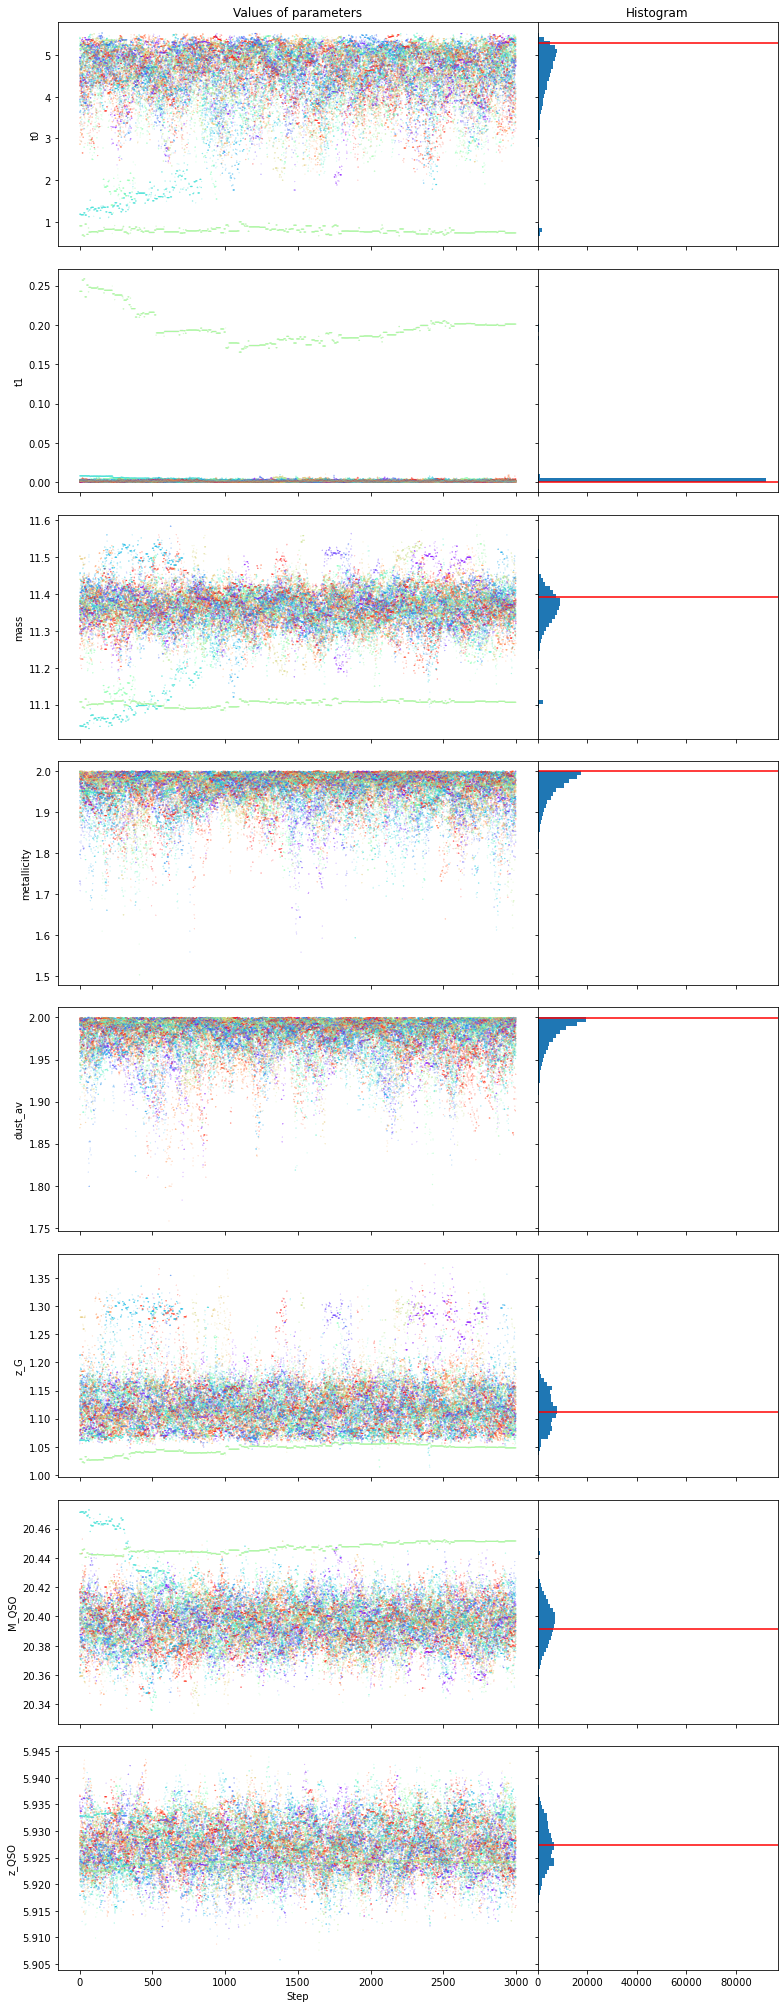

In [40]:
def show_convergence(samples, log_prob, obj_type, burn=0):
    samples = samples[burn:]
    log_prob = log_prob[burn:]
    nparams = samples.shape[2]
    fg, axs = plt.subplots(nparams,2,figsize=(11,4+3*nparams), sharey='row', sharex='col',
                           gridspec_kw={'width_ratios':[2,1]})
    flat_samples = samples.reshape(
        (samples.shape[0]*samples.shape[1],nparams)
    )
    pred_params = flat_samples[np.argmax(log_prob)]
    params = ["t0","t1","mass", "metallicity", "dust_av", "z_G", "M_QSO", 'z_QSO']
    if obj_type=='G':
        params = params[:6]
    elif obj_type=='Q':
        params = params[6:]
    for i in range(nparams):
        param_samples = samples[:,:,i].reshape(samples.shape[0]*samples.shape[1])
        
        x = np.tile(np.arange(samples.shape[0]), (samples.shape[1],1)).T.reshape(samples.shape[0]*samples.shape[1])
        axs[i,0].scatter(x, param_samples,
                         s=.01, c=np.arange(param_samples.shape[0])%samples.shape[1],
                         cmap='rainbow')
        axs[i,0].set_ylabel(params[i])
        axs[i,1].hist(flat_samples[:,i], orientation='horizontal', bins=50)
        axs[i,1].axhline(pred_params[i], c='r')
    axs[0,0].set_title('Values of parameters')
    axs[0,1].set_title('Histogram')
    axs[nparams-1,0].set_xlabel('Step')
    fg.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.1)
    return fg
fg = show_convergence(samples, log_prob, 'GQ')